# 本代码功能
   ## 对总数据的数据进行话题分类

## 1.预处理

In [1]:
import os
import pandas as pd
import re
import jieba
import jieba.posseg as psg

D:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [10]:
output_path = '/lda/result'
# file_path = '/lda/data'
# os.chdir(file_path)
data = pd.read_csv("/dataset/origin_dataset.csv", low_memory=False)#content type
os.chdir(output_path)
dic_file = "/lda/stop_dic/dict.txt"
stop_file = "/lda/stop_dic/stopwords.txt"

In [11]:
def chinese_word_cut(mytext):
    jieba.load_userdict(dic_file)
    jieba.initialize()
    try:
        stopword_list = open(stop_file,encoding ='utf-8')
    except:
        stopword_list = []
        print("error in stop_file")
    stop_list = []
    flag_list = ['n','nz','vn']
    for line in stopword_list:
        line = re.sub(u'\n|\\r', '', line)
        stop_list.append(line)
    
    word_list = []
    #jieba分词
    seg_list = psg.cut(mytext)
    for seg_word in seg_list:
        word = re.sub(u'[^\u4e00-\u9fa5]','',seg_word.word)
        #word = seg_word.word  #如果想要分析英语文本，注释这行代码，启动下行代码
        find = 0
        for stop_word in stop_list:
            if stop_word == word or len(word)<2:     #this word is stopword
                    find = 1
                    break
        if find == 0 and seg_word.flag in flag_list:
            word_list.append(word)      
    return (" ").join(word_list)

In [12]:
data["content_cutted"] = data.content.apply(chinese_word_cut)

## 2.LDA分析

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [14]:
def print_top_words(model, feature_names, n_top_words):
    tword = []
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        topic_w = " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        tword.append(topic_w)
        print(topic_w)
    return tword

In [15]:
n_features = 1500 #提取1000个特征词语
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                max_features=n_features,
                                stop_words='english',
                                max_df = 0.5,
                                min_df = 10)
tf = tf_vectorizer.fit_transform(data.content_cutted)

In [16]:
n_topics = 4
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=50,
                                learning_method='batch',
                                learning_offset=50,
                                doc_topic_prior=0.1,
                                topic_word_prior=0.01,
                               random_state=0)
lda.fit(tf)

LatentDirichletAllocation(doc_topic_prior=0.1, learning_offset=50, max_iter=50,
                          n_components=4, random_state=0,
                          topic_word_prior=0.01)

### 2.1输出每个主题对应词语 

In [17]:
n_top_words = 25
tf_feature_names = tf_vectorizer.get_feature_names_out()
topic_word = print_top_words(lda, tf_feature_names, n_top_words)

Topic #0:
疫情 影响 医院 工作 车辆 小区 人员 公司 列车 病例 酒店 免费 情况 核酸 记者 检测 高铁 旅客 服务 防控 新闻 供电 市场 企业 铁路
Topic #1:
地区 防汛 天气 预警 部分 应急 等地 局地 工作 小时 降雨 影响 强降水 预计 降水量 大风 局部 灾害 过程 强对流 气象台 全省 降水 极端 气象
Topic #2:
救援 消防 救援队 积水 群众 消防员 人员 车辆 力量 电话 小时 物资 地铁 老人 医院 村民 现场 道路 急需 隧道 小区 新闻 联系 男子 大家
Topic #3:
救援 物资 人民 大家 爱心 力量 防汛 救灾 灾区 全国 志愿者 灾情 公益 时候 网友 抗洪 时间 灾难 粉丝 百合 新闻 灾害 鸿星尔克 司机 企业


### 2.2输出每篇文章对应主题 

In [18]:
import numpy as np

In [19]:
topics=lda.transform(tf)

In [22]:
topic = []
for t in topics:
    topic.append("Topic #"+str(list(t).index(np.max(t))))
data['概率最大的主题序号']=topic
data['每个主题对应概率']=list(topics)
data.to_csv("data_topic.csv",index=False)

### 2.3可视化 

In [23]:
import pyLDAvis
import pyLDAvis.sklearn

In [25]:
pyLDAvis.enable_notebook()
pic = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.display(pic)
pyLDAvis.save_html(pic, 'LDA_pass'+str(n_topics)+'.html')
pyLDAvis.display(pic)
#去工作路径下找保存好的html文件


D:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \


### 2.4困惑度 

In [37]:
import matplotlib.pyplot as plt

In [38]:
plexs = []
scores = []
n_max_topics = 12
for i in range(1,n_max_topics):
    print(i)
    lda = LatentDirichletAllocation(n_components=i, max_iter=50,
                                    learning_method='batch',
                                    learning_offset=50,random_state=0)
    lda.fit(tf)
    plexs.append(lda.perplexity(tf)) 
    scores.append(lda.score(tf))

1
2
3
4
5
6
7
8
9
10
11


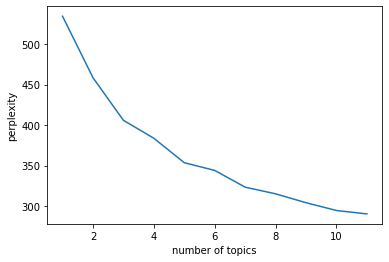

In [39]:
n_t=11#区间最右侧的值。注意：不能大于n_max_topics
x=list(range(1,n_t+1))
plt.plot(x,plexs[0:n_t])
plt.xlabel("number of topics")
plt.ylabel("perplexity")
plt.show()

In [26]:
# 困惑度是逐级下降的，但是经过试验，4个话题分类是最合适的

In [29]:
print(data['概率最大的主题序号'])

0        Topic #3
1        Topic #3
2        Topic #1
3        Topic #2
4        Topic #2
           ...   
91262    Topic #1
91263    Topic #1
91264    Topic #1
91265    Topic #1
91266    Topic #1
Name: 概率最大的主题序号, Length: 91267, dtype: object
